# Konfiguracja terminala i colaba


Instalacja terminala dla google colab

In [5]:
!pip install colab-xterm
%load_ext colabxterm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 3.0 MB/s eta 0:00:00


Kopiowanie zbioru danych:


curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

unzip -q kagglecatsanddogs_5340.zip

In [6]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

Dostęp do google drive z google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Przygotowanie do uczenia sieci


Zbiór danych do uczenia: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/data

Po odrzuceniu uszkodzonych plików, otrzymaliśmy 18728 plików w zestawie uczącym oraz 4682 plików w zestawie walidacyjnym.
Zbiór zawiera kolorowe obrazy psów i kotów z różnych perspektyw(co
zwiększa trudność poprawnej klasyfikacji dla sieci neuronowej). Obrazy zapi-
sane są w formacie .jpg w różnych rozmiarach (zostaną one przeskalowane
do rozmiaru wejścia sieci w trakcie wczytywania danych). Obrazy zapisane
zostały w dwóch folderach jeden ze zdjęciami kotów, a drugi ze zdjęciami
psów w celu łatwej weryfikacji poprawności wyjścia sieci w procesie uczenia

Importowanie bibliotek


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Usuwanie uszkodzonych plików

In [8]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


Przygotowanie danych do uczenia sieci - ustawienie rozmiaru zdjęcia na wejściu modelu, podział na zbiór uczący i walidujący, ustawienie rozmiaru zbioru obrazów w pojedynczym kroku uczenia

In [9]:
image_size = (90, 90)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1287,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


Drobne modyfikacje obrazów w celu zwiększenia puli obrazów dostępnych do uczenia sieci(odbicie oraz rotacja o losowy kąt)

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Kilka przykłądowych obrazów ze zbioru dla psów i kotów

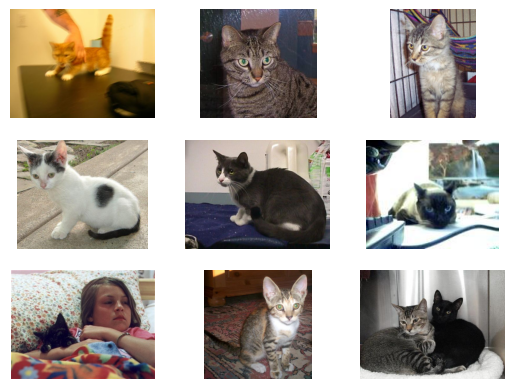

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

images = []

for i in range(9):
    images.append(mpimg.imread(f"PetImages/Cat/{i}.jpg"))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")


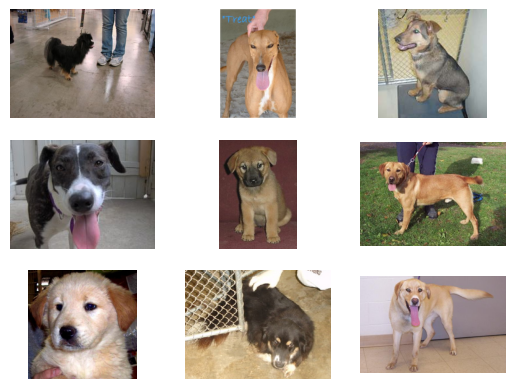

In [34]:
images = []

for i in range(9):
    images.append(mpimg.imread(f"PetImages/Dog/{1000 + i}.jpg"))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

plt.axis("off")
plt.show()

Podgląd działania funkcji do augmenacji danych

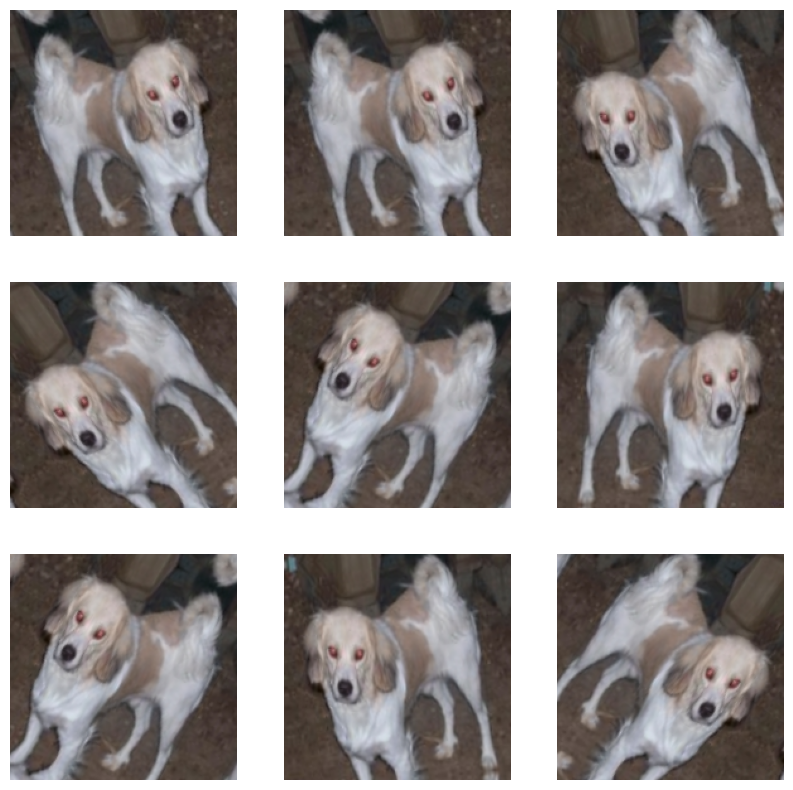

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(4):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Zmiana palety kolorów z rgb (0,255) na (0,1)

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

**Budowa modelu sieci**

1. Zdefiniowanie bloku wejściowego sieci odpowiedzialnego za:
* Przeskalowanie wejścia sieci
* Zastosowanie filtrów konwolucyjnych w celu wykrycia wzorców na
obrazie oraz zmniejszenie przestrzennego rozmiaru obrazu z jed-
noczesnym zachowaniem istotnych dla sieci informacji.
* Normalizację zwiększającą stabilność sieci oraz prędkość uczenia.
* Wybieramy funkcję aktywacji
2. Dodanie do modelu wybranej ilości bloków warstw o zdefiniowanym
rozmiarze w przypadku poniższej sieci są to bloki o rozmiarach 128,
256, 512. Każdy z bloków składa się z:
* Dwóch bloków złożonych z:
* * Funkcji aktywacji.
* * Warstwy SeparableConv2D - pozwala ona na przeprowadzenie
konwolucji podzielonej na etapy i zebranie wyników co zmniejsza ilość wymaganych obliczeń.
* *  Warstwy normalizującej.
* Warstwy MaxPooling2D, która próbkuje dane wejściowe wzdłuż ich wymiarów przestrzennych (wysokości i szerokości), pobierając maksymalną wartość z okna wejściowego (o rozmiarze określonym przez pool_size).
* Warstwa konwolucyjna z dodawaniem wyniku poprzedniej funkcji
aktywacji. Pozwala to na uczenie sieci cech szczególnych wybranego zestawu danych.
3. Warstwa GlobalAveragePooling2D służąca do obliczenia wartości średniej ze wszystkich cech. Pozwala na zredukowanie wymiarów przestrzennych w celu dalszego przetwarzania.
4. Warstwa dropout wyłączająca losowo wybrane fragmenty modelu na podstawie podanego prawdopodobieństwa. Ma na celu zapobieganie przeuczeniu sieci.
5. Warstwa dense odpowiedzialna za zebranie wyników z pozostałych warstw
i dopasowanie wartości wejściowych do poszczególnej klasy na wyjściu.
Funkcją aktywacji jest sigmoid ponieważ sieć ma za zadanie rozwiązywanie problemu z 2 klasami do rozpznawania na wyjściu.

Poniżej(pod kodem) graficzne przedstawienie modelu sieci

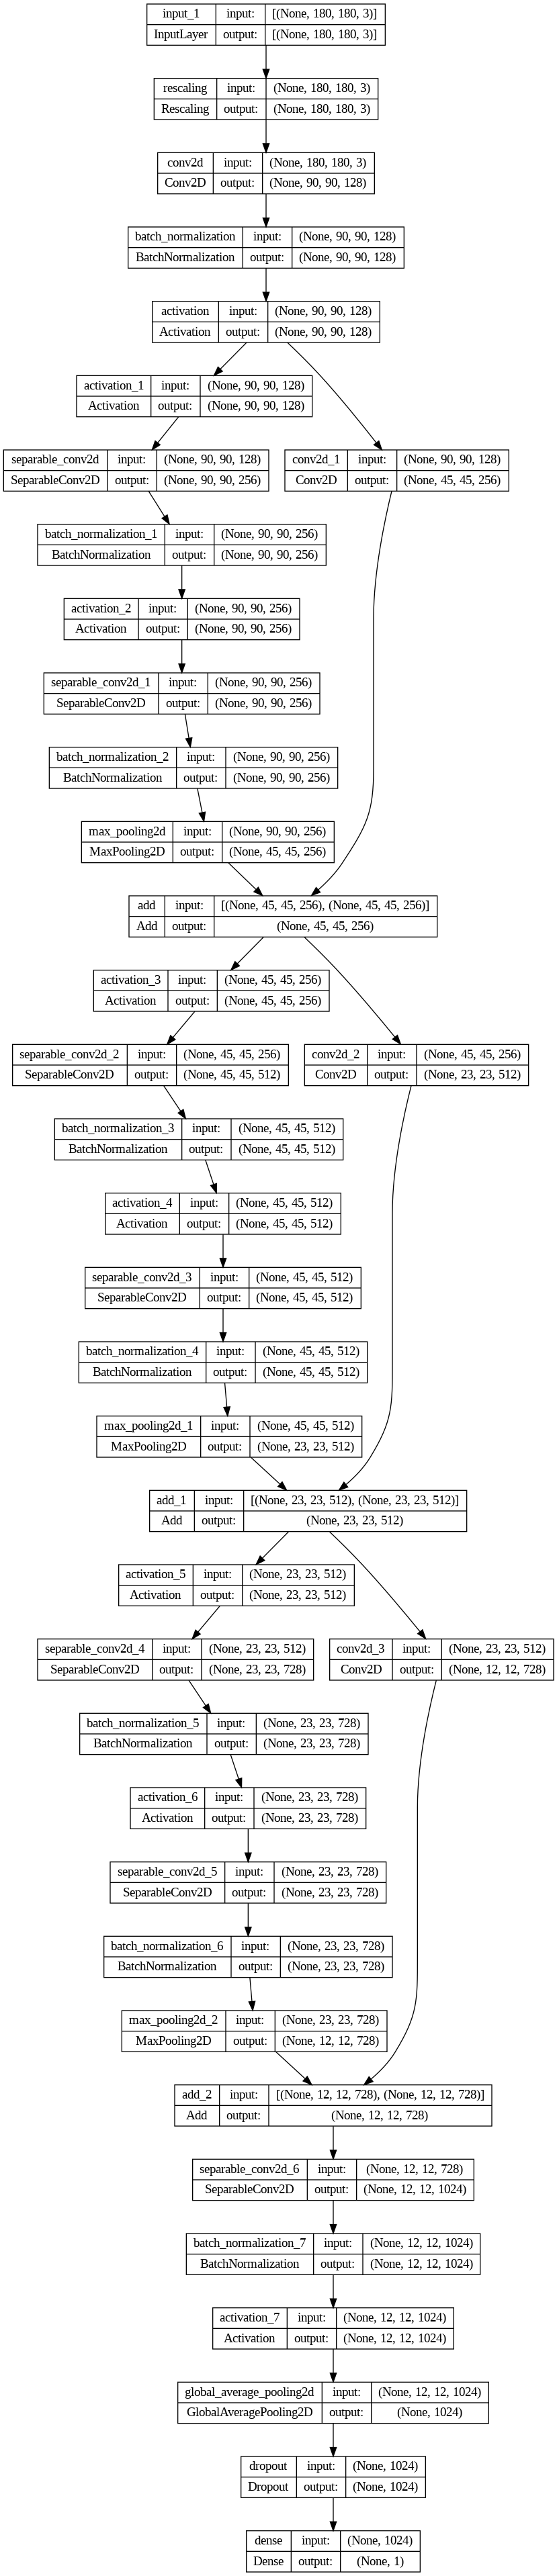

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# Uczenie sieci

Jako metrykę do pomiaru skuteczności działania sieci w trakcie uczenia
wykorzystano klasę BinaryAccuracy z biblioteki keras. Klasa ta pozwala na
wyliczenie wartości accuracy oraz loss osobno dla zbioru uczącego oraz walidacyjnego.
* Accuracy - wyliczane jest na podstawie porównania dopasowania na
wyjściu sieci z rzeczywistą klasą przynależności, do której należy dany
obraz. Wartość ta pokazuje procentową ilość poprawnych dopasowań
przez sieć.
* Loss - wyliczana jest z wykorzystaniem algorytmu wstecznej propagacji i wykorzystywana do określenia stopnia nauczenia sieci. Wartość loss
pozwala na modyfikację wag w poprzez minimalizację tej wartości w
trakcie uczenia. Jest również wykorzystywana do określania postępów uczenia oraz wykrywania przeuczenia sieci.
Uczenie przerywane jest w momencie osiągnięcia ustawionej liczby epok
lub w momencie znacznego wzrostu wartości loss względem poprzedniej epoki.


In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


Przebieg uczenia sieci(wartości loss i accuracy dla zbioru uczącego oraz val_los, val_acc dla zbioru walidacyjnego)

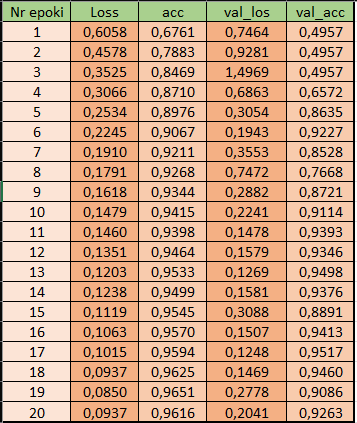

Wykres przedstawiający wartości z powyższej tabeli

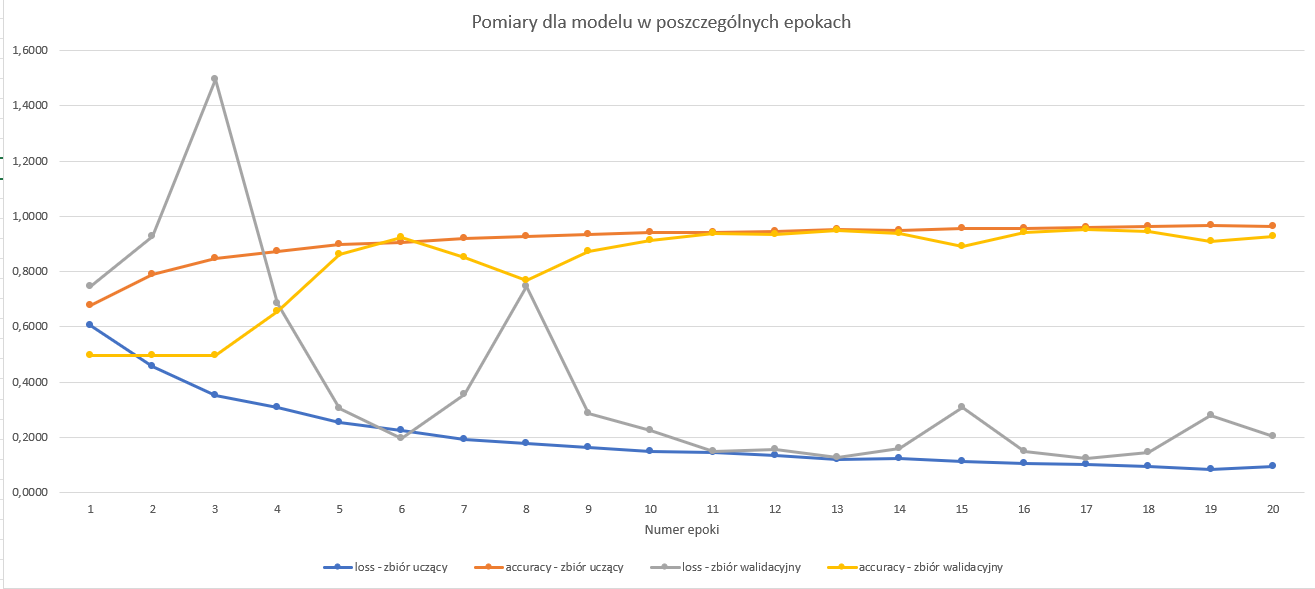

Sprawdzenie kożystając z sieci dla wybranego obrazu, zwraca na ile procent sieć klasyfikuje obraz na wejściu jako zdjęcie kota a na ile jako zdjęcie psa.

In [ ]:
img = keras.utils.load_img(
    "PetImages/d.png", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

Zapis nauczonego modelu

In [ ]:
model.save("model_kot_piesssz.keras")

Wczytanie zapisanego wcześniej modelu

In [ ]:
image_size = (90, 90)
batch_size = 128
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



loaded_model = tf.keras.saving.load_model("/content/drive/MyDrive/model_kot_piesssz.keras")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Testowanie modelu dla zbioru testowego

In [ ]:
from os import listdir
from os.path import isfile, join

cats = [f for f in listdir("/content/drive/MyDrive/modele/test_set/cats") if isfile(join("/content/drive/MyDrive/modele/test_set/cats", f))]
dogs = [f for f in listdir("/content/drive/MyDrive/modele/test_set/dogs") if isfile(join("/content/drive/MyDrive/modele/test_set/dogs", f))]

failed_paths = ""

tests_count = 999

cat_sum = 0
dog_sum = 0

for x in range(0, tests_count):
    path = "/content/drive/MyDrive/modele/test_set/cats/" + cats[x]
    img = keras.utils.load_img(
    path, target_size=image_size
    )

    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = loaded_model.predict(img_array)
    score = float(predictions[0])
    sc = 100 * (1 - score)
    if sc >= 75:
      cat_sum += sc
    else:
      failed_paths += path + "@"

for x in range(0, tests_count):
    path = "/content/drive/MyDrive/modele/test_set/dogs/" + dogs[x]
    img = keras.utils.load_img(
    path, target_size=image_size
    )

    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = loaded_model.predict(img_array)
    score = float(predictions[0])
    sc = 100 * score
    if sc >= 75:
      dog_sum += sc
    else:
      failed_paths += path + "@"

cat_ac = cat_sum / tests_count
print("Rozpoznawanie kotów: ")
print(cat_ac)
print("% ")

dog_ac = dog_sum / tests_count
print("Rozpoznawanie psów: ")
print(dog_ac)
print("%")

for txt in failed_paths.split("@"):
  print(txt)

* Rozpoznawanie kotów:
91.22479958449063
%
* Rozpoznawanie psów:
90.79899019412547
%




* Rozpoznawanie kotów: (rozpoznanie z minimum 75% pewności)
85.19100688351786
%
* Rozpoznawanie psów: (rozpoznanie z minimum 75% pewności)
85.34620912583382
%